# Load libraries and set device up

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

from libraries.dataset      import generate_dataset, standardize_dataset
from libraries.model        import GCNN, train, test, EarlyStopping
from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
n_epochs      = 100
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2
train_ratio   = 0.5
test_ratio    = 0.25  # val_ratio = 1 - train_ratio - test_ratio

dpi = 50

target = 'bandgap'
folder = 'bandgaps-MChX'

input_folder  = 'models'
target_folder = f'{input_folder}/{folder}'
model_name    = f'{target_folder}/{target}-model.pt'

# Generate or load graph database for training

In [3]:
labels_name                  = f'{target_folder}/labels.pt'
dataset_name                 = f'{target_folder}/dataset.pt'
dataset_name_std             = f'{target_folder}/standardized_dataset.pt'
labels_name_std              = f'{target_folder}/standardized_labels.pt'
standardized_parameters_name = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if not any(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name, labels_name_std, dataset_name, labels_name]):
    # Generate data
    generate_dataset('/home/claudio/cibran/Work/UPC/CLUE/Loaded_PhaseTransition',
                     targets=['EPA', 'bandgap'],
                     data_folder=target_folder)

if all(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name, labels_name_std]):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name_std)
    
    # Load the data from the JSON file
    with open(standardized_parameters_name, 'r') as json_file:
        numpy_dict = json.load(json_file)
    
    # Convert torch tensors to numpy arrays
    standardized_parameters = {}
    for key, value in numpy_dict.items():
        try:
            standardized_parameters[key] = torch.tensor(value)
        except:
            standardized_parameters[key] = value

elif all(os.path.exists(path) for path in [dataset_name, labels_name]):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, labels, standardized_parameters = standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    torch.save(labels,  labels_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in standardized_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value
    
    # Dump the dictionary with numpy arrays to a JSON file
    with open(standardized_parameters_name, 'w') as json_file:
        json.dump(numpy_dict, json_file)  

# Load the data from the JSON file
with open(f'{target_folder}/dataset_parameters.json', 'r') as json_file:
    dataset_parameters = json.load(json_file)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(dataset_parameters['database_target']) if t == target][0]
standardized_parameters['target_mean'] = standardized_parameters['target_mean'][target_idx]
standardized_parameters['target_std']  = standardized_parameters['target_std'][target_idx]

# Defining target factor
target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

# Select the target we want
for data in dataset:
    data.y = data.y[target_idx]

/tmp/ipykernel_250195/2796811874.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name_std)
/tmp/ipykernel_250195/2796811874.py:16: FutureWa

Split dataset

In [4]:
# Define the sizes of the train and test sets
# Corresponds to the size wrt the number of unique materials in the dataset
train_size = int(train_ratio * len(dataset))
test_size  = int(test_ratio  * len(dataset))

np.random.shuffle(dataset)

# Random, fast splitting
train_dataset = dataset[:train_size]
val_dataset   = dataset[train_size:-test_size]
test_dataset  = dataset[-test_size:]

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 62
Number of validation graphs: 32
Number of testing    graphs: 31


Define data loaders.

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [6]:
model = GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'), map_location=torch.device(device), weights_only=False)
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(7, 32)
    (conv2): GraphConv(32, 32)
    (linconv1): Linear(in_features=32, out_features=32, bias=True)
    (linconv2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion 

In [7]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=model_name)

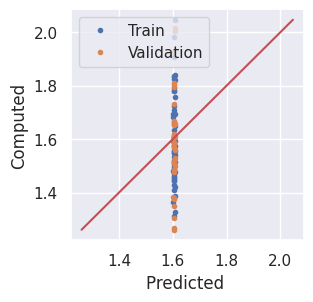

Epoch: 1, Train MAE: 0.1547, Val MAE: 0.1927
Epoch: 2, Train MAE: 0.1544, Val MAE: 0.1925
Epoch: 3, Train MAE: 0.1543, Val MAE: 0.1922
Epoch: 4, Train MAE: 0.1541, Val MAE: 0.1920
Epoch: 5, Train MAE: 0.1539, Val MAE: 0.1917


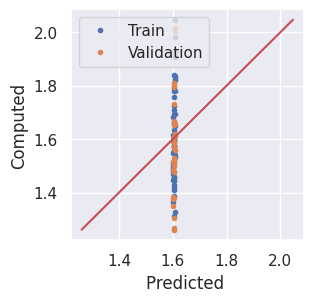

Epoch: 6, Train MAE: 0.1536, Val MAE: 0.1914
Epoch: 7, Train MAE: 0.1534, Val MAE: 0.1911
Epoch: 8, Train MAE: 0.1534, Val MAE: 0.1908
Epoch: 9, Train MAE: 0.1529, Val MAE: 0.1905
Epoch: 10, Train MAE: 0.1528, Val MAE: 0.1901


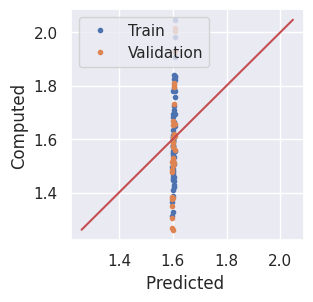

Epoch: 11, Train MAE: 0.1528, Val MAE: 0.1898
Epoch: 12, Train MAE: 0.1522, Val MAE: 0.1894
Epoch: 13, Train MAE: 0.1519, Val MAE: 0.1889
Epoch: 14, Train MAE: 0.1514, Val MAE: 0.1885
Epoch: 15, Train MAE: 0.1513, Val MAE: 0.1880


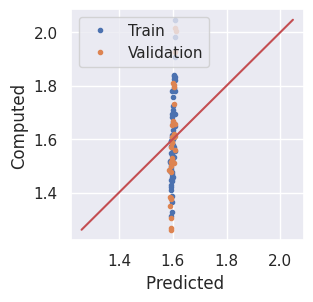

Epoch: 16, Train MAE: 0.1508, Val MAE: 0.1875
Epoch: 17, Train MAE: 0.1502, Val MAE: 0.1869
Epoch: 18, Train MAE: 0.1501, Val MAE: 0.1863
Epoch: 19, Train MAE: 0.1496, Val MAE: 0.1857
Epoch: 20, Train MAE: 0.1491, Val MAE: 0.1851


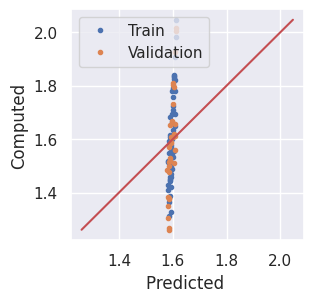

Epoch: 21, Train MAE: 0.1490, Val MAE: 0.1843
Epoch: 22, Train MAE: 0.1481, Val MAE: 0.1836
Epoch: 23, Train MAE: 0.1481, Val MAE: 0.1828
Epoch: 24, Train MAE: 0.1470, Val MAE: 0.1819
Epoch: 25, Train MAE: 0.1461, Val MAE: 0.1810


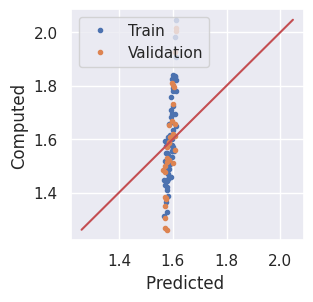

Epoch: 26, Train MAE: 0.1457, Val MAE: 0.1800
Epoch: 27, Train MAE: 0.1455, Val MAE: 0.1790
Epoch: 28, Train MAE: 0.1444, Val MAE: 0.1779
Epoch: 29, Train MAE: 0.1435, Val MAE: 0.1767
Epoch: 30, Train MAE: 0.1435, Val MAE: 0.1755


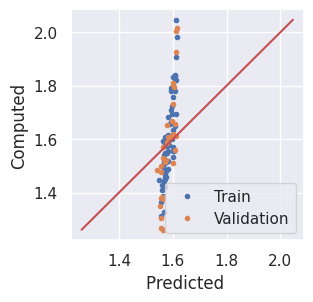

Epoch: 31, Train MAE: 0.1416, Val MAE: 0.1742
Epoch: 32, Train MAE: 0.1413, Val MAE: 0.1728
Epoch: 33, Train MAE: 0.1408, Val MAE: 0.1714
Epoch: 34, Train MAE: 0.1387, Val MAE: 0.1699
Epoch: 35, Train MAE: 0.1384, Val MAE: 0.1684


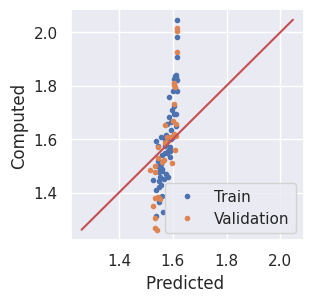

Epoch: 36, Train MAE: 0.1374, Val MAE: 0.1668
Epoch: 37, Train MAE: 0.1367, Val MAE: 0.1652
Epoch: 38, Train MAE: 0.1350, Val MAE: 0.1635
Epoch: 39, Train MAE: 0.1337, Val MAE: 0.1618
Epoch: 40, Train MAE: 0.1335, Val MAE: 0.1600


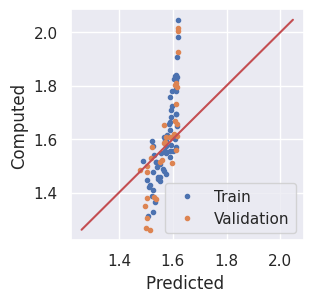

Epoch: 41, Train MAE: 0.1320, Val MAE: 0.1583
Epoch: 42, Train MAE: 0.1310, Val MAE: 0.1566
Epoch: 43, Train MAE: 0.1307, Val MAE: 0.1550
Epoch: 44, Train MAE: 0.1278, Val MAE: 0.1533
Epoch: 45, Train MAE: 0.1273, Val MAE: 0.1516


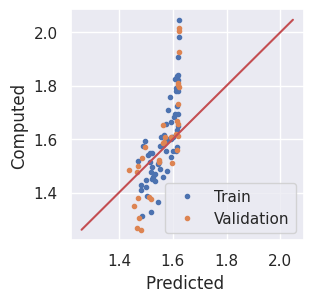

Epoch: 46, Train MAE: 0.1281, Val MAE: 0.1500
Epoch: 47, Train MAE: 0.1242, Val MAE: 0.1484
Epoch: 48, Train MAE: 0.1243, Val MAE: 0.1470
Epoch: 49, Train MAE: 0.1258, Val MAE: 0.1456
Epoch: 50, Train MAE: 0.1222, Val MAE: 0.1443


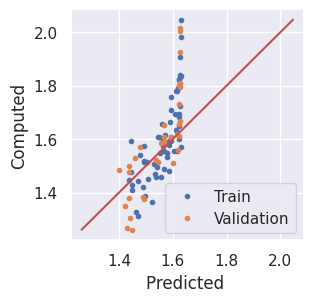

Epoch: 51, Train MAE: 0.1235, Val MAE: 0.1431
Epoch: 52, Train MAE: 0.1207, Val MAE: 0.1419
Epoch: 53, Train MAE: 0.1197, Val MAE: 0.1407
Epoch: 54, Train MAE: 0.1177, Val MAE: 0.1396
Epoch: 55, Train MAE: 0.1172, Val MAE: 0.1385


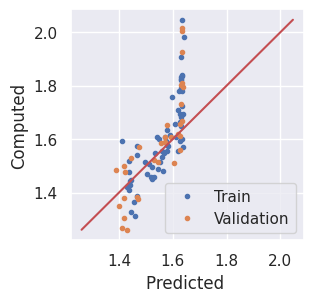

Epoch: 56, Train MAE: 0.1170, Val MAE: 0.1374
Epoch: 57, Train MAE: 0.1154, Val MAE: 0.1363
Epoch: 58, Train MAE: 0.1159, Val MAE: 0.1351
Epoch: 59, Train MAE: 0.1161, Val MAE: 0.1338
Epoch: 60, Train MAE: 0.1123, Val MAE: 0.1326


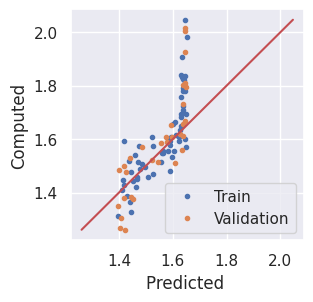

Epoch: 61, Train MAE: 0.1115, Val MAE: 0.1314
Epoch: 62, Train MAE: 0.1089, Val MAE: 0.1300
Epoch: 63, Train MAE: 0.1098, Val MAE: 0.1286
Epoch: 64, Train MAE: 0.1102, Val MAE: 0.1272
Epoch: 65, Train MAE: 0.1084, Val MAE: 0.1258


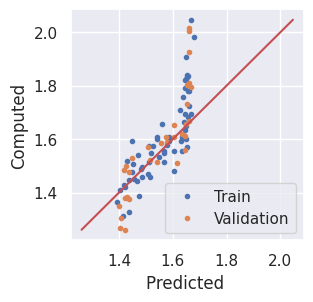

Epoch: 66, Train MAE: 0.1050, Val MAE: 0.1245
Epoch: 67, Train MAE: 0.1058, Val MAE: 0.1230
Epoch: 68, Train MAE: 0.1013, Val MAE: 0.1215
Epoch: 69, Train MAE: 0.1027, Val MAE: 0.1199
Epoch: 70, Train MAE: 0.1006, Val MAE: 0.1182


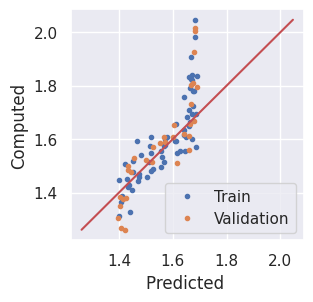

Epoch: 71, Train MAE: 0.0976, Val MAE: 0.1164
Epoch: 72, Train MAE: 0.0965, Val MAE: 0.1146
Epoch: 73, Train MAE: 0.0966, Val MAE: 0.1129
Epoch: 74, Train MAE: 0.0926, Val MAE: 0.1110
Epoch: 75, Train MAE: 0.0937, Val MAE: 0.1090


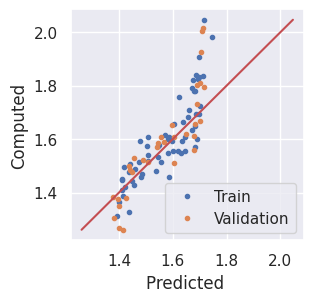

Epoch: 76, Train MAE: 0.0904, Val MAE: 0.1070
Epoch: 77, Train MAE: 0.0892, Val MAE: 0.1050
Epoch: 78, Train MAE: 0.0856, Val MAE: 0.1030
Epoch: 79, Train MAE: 0.0893, Val MAE: 0.1009
Epoch: 80, Train MAE: 0.0846, Val MAE: 0.0992


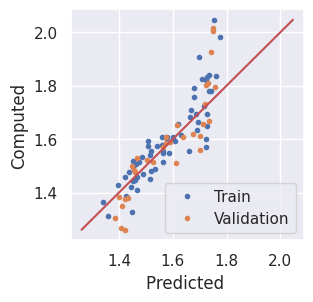

Epoch: 81, Train MAE: 0.0783, Val MAE: 0.0979
Epoch: 82, Train MAE: 0.0794, Val MAE: 0.0964
Epoch: 83, Train MAE: 0.0800, Val MAE: 0.0939
Epoch: 84, Train MAE: 0.0749, Val MAE: 0.0912
Epoch: 85, Train MAE: 0.0743, Val MAE: 0.0889


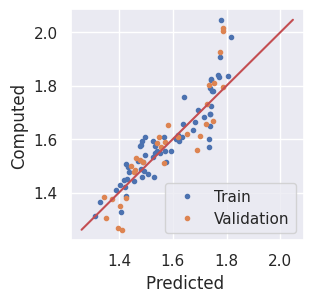

Epoch: 86, Train MAE: 0.0709, Val MAE: 0.0871
Epoch: 87, Train MAE: 0.0708, Val MAE: 0.0853
Epoch: 88, Train MAE: 0.0731, Val MAE: 0.0838
Epoch: 89, Train MAE: 0.0689, Val MAE: 0.0825
Epoch: 90, Train MAE: 0.0668, Val MAE: 0.0812


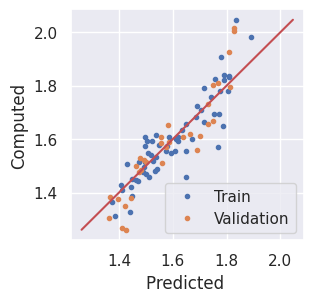

Epoch: 91, Train MAE: 0.0689, Val MAE: 0.0795
Epoch: 92, Train MAE: 0.0630, Val MAE: 0.0779
Epoch: 93, Train MAE: 0.0628, Val MAE: 0.0763
Epoch: 94, Train MAE: 0.0604, Val MAE: 0.0749
Epoch: 95, Train MAE: 0.0618, Val MAE: 0.0738


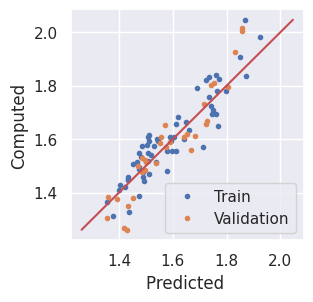

Epoch: 96, Train MAE: 0.0625, Val MAE: 0.0730
Epoch: 97, Train MAE: 0.0640, Val MAE: 0.0726
Epoch: 98, Train MAE: 0.0624, Val MAE: 0.0721
Epoch: 99, Train MAE: 0.0628, Val MAE: 0.0724
Epoch: 100, Train MAE: 0.0586, Val MAE: 0.0733


In [8]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = train(model, criterion, train_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device),
                                                               optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_predictions, train_ground_truths, '.', label='Train')
        plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
        plt.xlabel(r'Predicted ')
        plt.ylabel(r'Computed')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

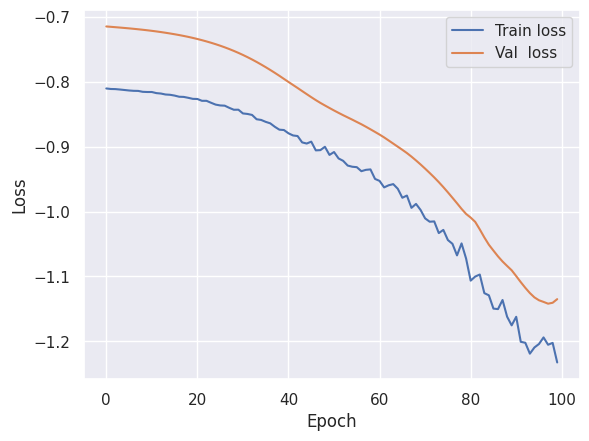

In [9]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

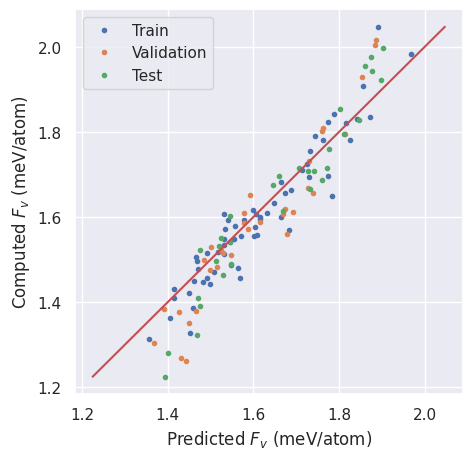

Train MAE: 0.0506, Val MAE: 0.0733, Test MAE: 0.0688


In [10]:
train_loss, train_predictions, train_ground_truths = test(model, criterion, train_loader,
                                                          target_factor.to(device),
                                                          standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  test(model, criterion, test_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.plot(train_predictions, train_ground_truths, '.', label='Train')
plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
plt.plot(test_predictions,  test_ground_truths,  '.', label='Test')
plt.xlabel(r'Predicted $F_v$ (meV/atom)')
plt.ylabel(r'Computed $F_v$ (meV/atom)')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [11]:
dataset = torch.load(dataset_name_std)
labels  = torch.load(labels_name_std)

dataset = dataset[:train_size]
labels  = labels[:train_size]

torch.save(dataset, f'{target_folder}/r_dataset_std.pt')
torch.save(labels,  f'{target_folder}/r_labels_std.pt')

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = test(model, criterion, loader,
                                        target_factor.to(device),
                                        standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

/tmp/ipykernel_250195/408267666.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name_std)
/tmp/ipykernel_250195/408267666.py:2: FutureWarnin

array([-0.07287157,  0.13059998,  0.01561058, -0.00139523,  0.05038023,
       -0.1619829 , -0.03535819, -0.05958259, -0.01697421, -0.01522064,
       -0.18215263, -0.02857101,  0.09655571,  0.05053329,  0.01658213,
       -0.03715456, -0.01181042,  0.05176067, -0.07286727, -0.0977515 ,
        0.00230491, -0.08642149, -0.0546881 , -0.01706278, -0.00500417,
       -0.03468668,  0.02949238, -0.05529916, -0.11839342,  0.03936827,
       -0.02189171,  0.1023078 ,  0.02375424,  0.00711274,  0.0242461 ,
       -0.03208673, -0.16943872,  0.01820397, -0.01629519, -0.06364357,
        0.05125868, -0.05159318, -0.01546502, -0.05650067, -0.14522839,
        0.0273124 , -0.04192662, -0.11185884, -0.07979393, -0.06195307,
       -0.06059051,  0.02385569, -0.00917256, -0.02026939,  0.01122832,
       -0.06443763, -0.06487596, -0.12493598, -0.0570513 , -0.01195812,
        0.02624762,  0.0668608 ], dtype=float32)

In [12]:
# Generate dictionnary with uncertinty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx, label in enumerate(labels):
    uncertainty_data.update(
        {label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(f'{target_folder}/uncertainty_data.json', 'w') as json_file:
    json.dump(uncertainty_data, json_file)  